In [12]:
from posixpath import abspath
import sys,os
from pathlib import Path
import tensorflow as tf
sys.path.insert(0,os.path.join('Code/Preprocess'))

import torch
import torch.nn as nn

import tensorflow as tf # Adding padding to our dataset (train and test models)
import numpy as np
from DataPreparation import dataPrepare

import warnings
warnings.filterwarnings("ignore")

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [13]:
class Data:

    def __init__(self,path) -> None:
        self.path = path

    def getData(self):
        """Considers the path of the dataset which holds the sparse matrix. With the help of tensorflow we are
        creating the padding for our dataset (X_train and X_test).

        Returns:
            Tensor: Tensor data with padding and dataframe
        """
        fetchData = dataPrepare()
    
        X_train, X_test, y_train, y_test =  fetchData.Vectorizer(self.path)

        # Adding the padding to our sparse matrix
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train.todense())
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test.todense())

        # make training and test sets in torch
        x_train = torch.from_numpy(X_train).type(torch.Tensor)
        x_test = torch.from_numpy(X_test).type(torch.Tensor)
        y_train = torch.from_numpy(y_train.to_numpy()).type(torch.Tensor)
        y_test = torch.from_numpy(y_test.to_numpy()).type(torch.Tensor)
        
        print(f'Size of our y-train dataset is {y_train.size()} and X-train dataset is {x_train.size()}')

        return x_train,x_test,y_train,y_test

In [91]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """LSTM model which takes the following input:
                - Input Dimension
                - Hidden Layers (Number)
                - Total Number of Layers
                - Ouput Diemension

        Args:
            input_dim (int): Length of the dataset
            hidden_dim (int): Total hidden layer
            num_layers (int): Total layers to be present
            output_dim (int): Number of output diemension layer
        """
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # https://discuss.pytorch.org/t/why-do-i-get-typeerror-expected-np-ndarray-got-numpy-ndarray-when-i-use-torch-from-numpy-function/37525/3
        x = torch.from_numpy(np.asarray(x)).type(torch.Tensor)
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers,tuple(x.size())[0] , self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, tuple(x.size())[0], self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [92]:
# create Dataset object to support batch training
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features             
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

In [226]:
class LSTMImplement:

    def __init__(self,path, hidden_dim, num_layers, output_dim) -> None:
        """A cosntructor which takes the path of the dataset, number of hidden dimensions, number of layers and output
        diemensions as our parameters. This will plot our accuracy plot and loss plot.

        Args:
            path (String): Path of our dataset
            hidden_dim (int): Total hidden layer
            num_layers (int): Total layers to be present
            output_dim (int): Number of output diemension layer
        """
        self.path = path
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

    def run(self):
        from torch.utils.data import DataLoader
        from sklearn.model_selection import train_test_split
        fetchData = dataPrepare()
        X_train, X_test, y_train, y_test =  fetchData.Vectorizer(self.path)
        x_train,x_test,y_train,y_test = Data(self.path).getData()
        x_val,_,y_val,_ = train_test_split(x_train,y_train,random_state=100,test_size=0.5)
        input_dimension = X_train.shape[1]
        model = LSTM(input_dim=input_dimension, hidden_dim=self.hidden_dim, output_dim=self.output_dim, num_layers=self.num_layers)

        # https://discuss.pytorch.org/t/valueerror-target-size-torch-size-16-must-be-the-same-as-input-size-torch-size-16-1/55232
        y_train = y_train.unsqueeze(1)
        y_train = y_train.float()
        loss_fn = torch.nn.BCEWithLogitsLoss()

        train_dataset = Dataset(x_train, y_train)
        dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True)
        optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
        
        print(len(list(model.parameters())))
        for i in range(len(list(model.parameters()))):
            print(list(model.parameters())[i].size())

        num_epochs = 100
        loss_val  = np.zeros(num_epochs)
        acc_val  = np.zeros(num_epochs)
        
        for t in range(num_epochs):
            model.train()
            for idx, (X_batch, Y_batch) in enumerate(dataloader):
                # Forward pass
                output = model(X_batch)  # conduct forward pass

                loss = loss_fn(output, Y_batch)
                loss += 0.001 * sum(p.abs().sum() for p in model.parameters())
                # if t % 10 == 0 and t !=0:
                #     print(f"Epoch {t} MSE is {loss.item()}")
                loss_val[t] = loss.item()

                # Zero out gradient, else they will accumulate between epochs
                optimiser.zero_grad()

                # Backward pass
                loss.backward()

                # Update parameters
                optimiser.step()
            
            with torch.no_grad():  # no need to calculate gradients when assessing accuracy

                model.eval()
                pred_train = model(x_train).numpy().argmax(axis=1)
                train_acc = (pred_train == y_train.numpy()).mean()
                pred_val = model(x_val).numpy().argmax(axis=1)
                val_acc = (pred_val == y_val.numpy()).mean()
                acc_val[t] = val_acc
        return acc_val,loss_val

In [227]:
acc,loss = LSTMImplement('YoutubeComplete.csv',32,1,2).run()

Size of our y-train dataset is torch.Size([952]) and X-train dataset is torch.Size([952, 1, 2701])
6
torch.Size([128, 2701])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([2, 32])
torch.Size([2])


ValueError: Target size (torch.Size([16, 1])) must be the same as input size (torch.Size([16, 2]))

Text(0.5, 0, 'epoch')

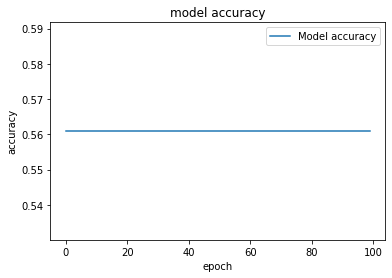

In [217]:
import matplotlib.pyplot as plt
plt.plot(acc, label="Model accuracy")
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

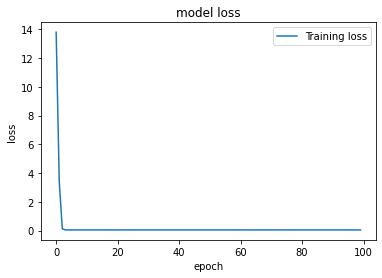

In [218]:
plt.plot(loss, label="Training loss")
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [141]:
# acc_val.unique()
np.unique(acc_val)[0] * 100

57.14285714285714

In [142]:
train_acc * 100

56.72268907563025

In [ ]:
def run(self):
    from torch.utils.data import DataLoader
    from sklearn.model_selection import train_test_split
    fetchData = dataPrepare()
    X_train, X_test, y_train, y_test =  fetchData.Vectorizer(self.path)
    x_train,x_test,y_train,y_test = Data(self.path).getData()
    x_val,_,y_val,_ = train_test_split(x_train,y_train,random_state=100,test_size=0.5)
    input_dimension = X_train.shape[1]
    model = LSTM(input_dim=input_dimension, hidden_dim=self.hidden_dim, output_dim=self.output_dim, num_layers=self.num_layers)

    # https://discuss.pytorch.org/t/valueerror-target-size-torch-size-16-must-be-the-same-as-input-size-torch-size-16-1/55232
    y_train = y_train.unsqueeze(1)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_dataset = Dataset(x_train, y_train)
    dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

    num_epochs = 100
    loss_val  = np.zeros(num_epochs)
    acc_val  = np.zeros(num_epochs)
    correct_values = 0
    for epochs in range(num_epochs):
        model.train()
        for idx, (inputs,labels) in enumerate(dataloader):
            # Forward pass
            output = model(inputs)  # conduct forward pass

            loss = loss_fn(output, labels)
            loss += 0.001 * sum(p.abs().sum() for p in model.parameters())
            # if t % 10 == 0 and t !=0:
            #     print(f"Epoch {t} MSE is {loss.item()}")
            loss_val[epochs] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()

            correct_values += (output == labels).float().sum()
            print(correct_values)
        # with torch.no_grad():  # no need to calculate gradients when assessing accuracy

        # model.eval()
        # accuracy = 100 * correct_values / len(y_train.numpy())
        # avg_loss = sum(loss) / len(y_train.numpy())
        # print(f"Accuracy is {accuracy} and avg loss is {avg_loss.item()}")
        # pred_train = model(x_train).detach().numpy().argmax(axis=1)
        # train_acc = (pred_train == y_train.detach().numpy()).mean()
        # pred_val = model(x_val).detach().numpy().argmax(axis=1)
        # val_acc = (pred_val == y_val.detach().numpy()).mean()
        # acc_val[epochs] = val_acc
    return acc_val,loss_val